# Projet 8 :  Participez à la conception d'une voiture autonome

<font color = "grey"><i> Chargement des modules necessaires </i></font>

In [3]:

from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import shutil
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib import colors
sns.set()
plt.style.use('ggplot')

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5453007558858102976
, name: "/device:DML:0"
device_type: "DML"
memory_limit: 7374940775
locality {
}
incarnation: 8472701786145973135
physical_device_desc: "{\"name\": \"Radeon RX 580 Series\", \"vendor_id\": 4098, \"device_id\": 26591, \"driver_version\": \"27.20.21002.112\"}"
]


In [5]:
print(tf.test.is_gpu_available()
)

True


# Funtions

## Creation of mask from grey scale image

In [6]:
def create_mask(img,cats):
    '''creates an mask from image and segmentation categories

    Args:
      img - PIL image
      cats - dict {'cat1':[value1,value2,value3,etc...],'cat2':[value1,value2,value3,etc...]}

    Returns:
      A mask of type np.array of dimension (shape(img),len(cats)) '''


    img =tf.keras.preprocessing.image.img_to_array(img,dtype=np.int32) # convert img to np.array
    img=np.squeeze(img) #remove 1 dimension
    mask = np.zeros((img.shape[0], img.shape[1], len(cats)),dtype=int) # create a mask with zeros
    flat_cat = [val for cat in list(cats.values()) for val in cat] # create a list of all values associated with categories
    ca_min=min(flat_cat)
    ca_max=max(flat_cat)
    cats_names=list(cats.keys())

    #for each values associated with a category, fill in the mask with the corresponding category number
    for i in range(ca_min,ca_max):
            for idx,name in enumerate(cats_names):
                if i in cats[name]:
                    mask[:,:,idx] = np.logical_or(mask[:,:,idx],(img==i))
    #print('mask',mask)
    return mask

## Construction of  colored image from mask

Class Definitions

| Class  | Représentation |
|-------------|-------------|
| void          | 	ground+ · dynamic+ · static+   |
| flat           |road · sidewalk · parking+ · rail track+      |
| construction          | building · wall · fence · guard rail+ · bridge+ · tunnel+  |
| object         | 	pole · pole group+ · traffic sign · traffic light          |
| nature         | vegetation · terrain          |
| sky         | sky         |
| human         |	person* · rider*        |
|vehicle        | 	car* · truck* · bus* · on rails* · motorcycle* · bicycle* · caravan*+ · trailer*+           |

Class Definitions

| Class  | Représentation |
|-------------|-------------|
| void          | 0,1,2,3,4,5,6       |
| flat           | 7,8,9,10        |
| construction          | 11,12,13,14,15,16         |
| object         | 17,18,19,20           |
| nature         | 21,22            |
| sky         | 23           |
| human         |24,25           |
|vehicle        | 26,27,28,29,30,31,32,33,-1            |

In [9]:
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

<font color = ""><b> generate_img_from_mask </b></font>
><font color = ""><i> Generate a PIL() image from a segmented mask and categorie cats with specified color palette for each cateorie </i></font>

In [ ]:
def generate_img_from_mask(mask,cats):
    colors_palette=['b','g','r','c','m','y','k','w']

    img_seg = np.zeros((mask.shape[0],mask.shape[1],3),dtype='float')
    for cat in range(len(cats)):
        img_seg[:,:,0] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[0]
        img_seg[:,:,1] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[1]
        img_seg[:,:,2] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[2]

    return tf.keras.preprocessing.image.array_to_img(img_seg)


<font color = ""><b> concat_h </b></font>
><font color = ""><i> concatenate two PIL horizontaly </i></font>

In [11]:

def concat_h(img1, img2):

    '''concatenate two PIL images horizontaly'''
    dst = Image.new('RGB', (img1.width + img2.width, img1.height))
    dst.paste(img1, (0, 0))
    dst.paste(img2, (img1.width, 0))
    return dst

<font color = ""><b> concat_h </b></font>
><font color = ""><i> show the img, reference mask and the predicted mask</i></font>

In [ ]:
def show_results(img,mask,model):
    img_norm = np.array(normalize_input_img(img))
    img_pred = model.predict(img_norm.reshape(1,128,256,3))[0]
    picture = concat_h(concat_h(img,generate_img_from_mask(create_mask(mask,cats),cats)),generate_img_from_mask(img_pred,cats))

    return picture

<font color = ""><b> normalize_input_img </b></font>
><font color = ""><i> Normalize PIL to fall in [-1,1] range, returns 3D numpy array</i></font>

In [12]:
def normalize_input_img(img):
    '''Normalize PIL image to fall in [-1,1] range, returns 3D numpy array'''
    img =tf.keras.preprocessing.image.img_to_array(img,dtype=np.int32)
    img = img/127.5
    img -= 1
    return img

# File

In [13]:
path="C:/Users/marj1/PycharmProjects/Project8/"
image_train_path="C:/Users/marj1/PycharmProjects/Project8/data/images/train"
mask_train_path="C:/Users/marj1/PycharmProjects/Project8/data/images/masks"

image_test_path="C:/Users/marj1/PycharmProjects/Project8/data/images/test/test"
mask_test_path="C:/Users/marj1/PycharmProjects/Project8/data/images/test/mask/"

In [14]:
image_train_filename = os.listdir(image_train_path)
mask_train_filename = os.listdir(mask_train_path)

image_test_filename = os.listdir(image_test_path)
mask_test_filename = os.listdir(mask_test_path)

## Exploratory data analysis


<font color = ""><b> Number of images for training </b></font>

In [15]:
len(image_train_filename)

2022

<font color = ""><b> Number of images for test </b></font>

In [16]:
len(image_test_filename)

544

In [17]:
test_img_file="data/images/train/dusseldorf_000000_000019_leftImg8bit.png"
test_mask_file="data/images/masks/dusseldorf_000000_000019_gtFine_labelIds.png"
img = tf.keras.preprocessing.image.load_img(test_img_file,target_size=(128,256))
mask = tf.keras.preprocessing.image.load_img(test_mask_file,target_size=(128,256),color_mode="grayscale")

### Class repartition

In [18]:
sums=[]
for file in mask_train_filename:
    mask_file=mask_train_path+'/'+file
    mask = tf.keras.preprocessing.image.load_img(mask_file,target_size=(128,256),color_mode="grayscale")
    mask_tensor = create_mask(mask,cats)
    sum=[]
    for i in range(8):
        sum.append(mask_tensor[:,:,i].sum())
    sums.append(sum)

In [19]:
sums=np.array(sums)

In [20]:
sums.sum(axis=0)

array([ 7093266, 25580547, 14110486,  1180906, 10469695,  2292175,
         793239,  4463018])

Text(0.5, 1.0, 'class repartition')

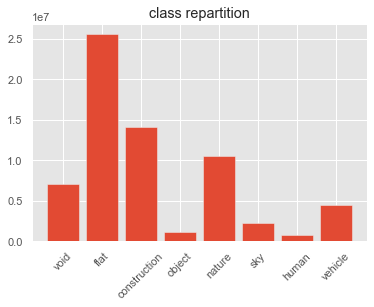

In [21]:
plt.bar(x=cats.keys(),height = sums.sum(axis=0),tick_label=list(cats.keys()))
plt.xticks(rotation=45)
plt.title('class repartition')

## dummy dataset
<font color = ""><b> Number of images for test </b></font>

let's use 100 training samples and 20 test sample randomly selected in the dataset

In [22]:
import random

In [23]:
rand_index_train=random.sample(range(0,len(image_train_filename)-1),100)
rand_index_test=random.sample(range(0,len(image_test_filename)-1),20)

In [24]:
image_train_filename=[image_train_filename[i] for i in rand_index_train]
mask_train_filename=[mask_train_filename[i] for i in rand_index_train]

image_test_filename=[image_test_filename[i] for i in rand_index_test]
mask_test_filename=[mask_test_filename[i] for i in rand_index_test]



In [25]:
X_train_dummy=[]
for file in image_train_filename:
    img_file=image_train_path+'/'+file
    img = tf.keras.preprocessing.image.load_img(img_file,target_size=(128,256))
    X_train_dummy.append(normalize_input_img(img))
X_train_dummy = np.array(X_train_dummy)

In [26]:
X_train_dummy.shape

(100, 128, 256, 3)

In [27]:
y_train_dummy=[]
for file in mask_train_filename:
    img_file=mask_train_path+'/'+file
    img = tf.keras.preprocessing.image.load_img(img_file,target_size=(128,256),color_mode="grayscale")
    y_train_dummy.append(create_mask(img,cats))
y_train_dummy = np.array(y_train_dummy)

In [28]:
X_train_dummy.shape

(100, 128, 256, 3)

In [29]:
X_test_dummy=[]
for file in image_test_filename:
    img_file=image_test_path+'/'+file
    img = tf.keras.preprocessing.image.load_img(img_file,target_size=(128,256))
    X_test_dummy.append(normalize_input_img(img))
X_test_dummy = np.array(X_test_dummy)

In [30]:
X_test_dummy.shape

(20, 128, 256, 3)

In [31]:
y_test_dummy=[]
for file in mask_test_filename:
    img_file=mask_test_path+'/'+file
    img = tf.keras.preprocessing.image.load_img(img_file,target_size=(128,256),color_mode="grayscale")
    y_test_dummy.append(create_mask(img,cats))
y_test_dummy = np.array(y_test_dummy)

In [32]:
y_test_dummy.shape

(20, 128, 256, 8)

# Data Augmentation


In [33]:
import imgaug.augmenters as iaa

## Gaussian Blur

<font color = ""><b> blur_img </b></font>
><font color = ""><i> Add random blur to image and returns PIL</i></font>

In [34]:
def blur_img(img):

    n = random.uniform(0,2.0) # Generating random value for sigma
    blur_transform = iaa.Sequential([iaa.GaussianBlur(sigma=n)])
    img_blur = blur_transform(image=tf.keras.preprocessing.image.img_to_array(img))

    return tf.keras.preprocessing.image.array_to_img(img_blur)

## Random zoom
<font color = ""><b> blur_img </b></font>
><font color = ""><i> Add random zoom to image and mask and returns transformed PIL with corresponding mask</i></font>

In [35]:
def zoom_img(img,mask):

    n = random.uniform(1,5) # Generating random value for sigma
    zoom_transform = iaa.Sequential([iaa.Affine(scale=n,order=0)]) # uses order=0 to avoid artifacts in mask
    img_zoom = zoom_transform(image=tf.keras.preprocessing.image.img_to_array(img))
    mask_zoom = zoom_transform(image=tf.keras.preprocessing.image.img_to_array(mask))

    return tf.keras.preprocessing.image.array_to_img(img_zoom), tf.keras.preprocessing.image.array_to_img(mask_zoom,scale=False)

## Random brightness
<font color = ""><b> brightness_img </b></font>
><font color = ""><i> Add random brightness to image and returns PIL</i></font>

In [36]:
def brightness_img(img):

    br_transform = iaa.Sequential([iaa.MultiplyBrightness((0.1,2))])
    img_br = br_transform(image=tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8))

    return tf.keras.preprocessing.image.array_to_img(img_br,scale=False)

## Horizontal Flip
<font color = ""><b> brightness_img </b></font>
><font color = ""><i> Flips Horizontaly image andreturns transformed PIL with corresponding mask</i></font>

In [37]:
def flip_img(img,mask):

    flip_transform = iaa.Sequential([iaa.Fliplr()])
    img_flip = flip_transform(image=tf.keras.preprocessing.image.img_to_array(img))
    mask_flip = flip_transform(image=tf.keras.preprocessing.image.img_to_array(mask))

    return tf.keras.preprocessing.image.array_to_img(img_flip), tf.keras.preprocessing.image.array_to_img(mask_flip,scale=False)

## Tests

In [38]:
img = tf.keras.preprocessing.image.load_img(test_img_file,target_size=(128,256))
mask = tf.keras.preprocessing.image.load_img(test_mask_file,target_size=(128,256),color_mode="grayscale")

<font color = "white"><i><h1> Data augmentation</h1>  </i></font>
<font color = "white"><i><h2>Original </h2>  </i></font>

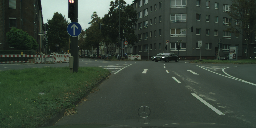

In [39]:
img

In [ ]:
generate_img_from_mask(create_mask(img,cats),cats)

<font color = "white"><i><h2>blur </h2>  </i></font>

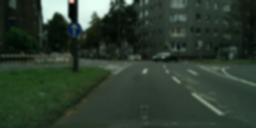

In [40]:
blur_img(img)

<font color = "white"><i><h2>Zoom </h2>  </i></font>

In [41]:
zooms = zoom_img(img,mask)

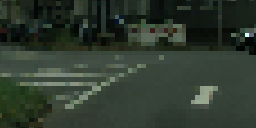

In [42]:
zooms[0]

<font color = "white"><i><h2>Mask </h2>  </i></font>

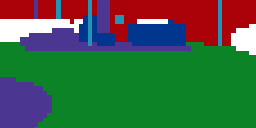

In [43]:
generate_img_from_mask(create_mask(zooms[1],cats),cats)

<font color = "white"><i><h2>brightness </h2>  </i></font>

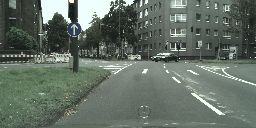

In [44]:
brightness_img(img)

<font color = "white"><i><h2>flips </h2>  </i></font>

In [45]:
flips = flip_img(img,mask)

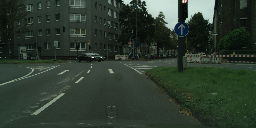

In [46]:
flips[0]

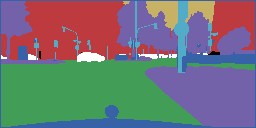

In [47]:
generate_img_from_mask(create_mask(flips[1],cats),cats)

# Data generator

In [48]:
from tensorflow.keras.utils import Sequence

<font color = ""><b> seg_gen </b></font>
><font color = ""><i> generate one batch with random index</i></font>

In [49]:
class seg_gen(Sequence):

    def __init__(self, image_dir,
                 mask_dir,
                 batch_size,
                 img_height,
                 img_width,
                 cats,
                 sample_perc=100,
                 aug_blur=False,
                 aug_zoom=False,
                 aug_brightness=False,
                 aug_flip=False):

        self.image_dir = image_dir
        self.mask_dir =  mask_dir
        self.image_filename =  os.listdir(image_dir)
        self.image_filename.sort()
        self.mask_filename =  os.listdir(mask_dir)
        self.mask_filename.sort()
        self.sample_perc = sample_perc
        # Generate a sample
        rdm_index = random.sample(range(0,len(self.image_filename)),int(len(self.image_filename)*self.sample_perc/100))
        image_filename_sample = []
        for i in rdm_index:
            image_filename_sample.append(self.image_filename[i])

        mask_filename_sample = []
        for i in rdm_index:
            mask_filename_sample.append(self.mask_filename[i])

        self.image_filename = image_filename_sample
        self.mask_filename = mask_filename_sample

        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.cats = cats
        self.sample_perc = sample_perc
        self.aug_blur = aug_blur
        self.aug_zoom = aug_zoom
        self.aug_brightness = aug_brightness
        self.aug_flip = aug_flip

    def __len__(self):
        return int(np.ceil(len(self.image_filename) / float(self.batch_size)))

    def __getitem__(self, idx):


        idx = np.random.randint(0,len(self.image_filename)-1, self.batch_size) #generate random index for the batch
        batch_img, batch_mask = [], []

        for i in idx:

            #filename
            img_file = self.image_dir+'/'+self.image_filename[i]
            mask_file = self.mask_dir+'/'+self.mask_filename[i]

            #Load as PIL and resize
            img = tf.keras.preprocessing.image.load_img(img_file,target_size=(self.img_height,self.img_width))
            mask = tf.keras.preprocessing.image.load_img(mask_file,target_size=(128,256),color_mode="grayscale")

            #Normalize image and create mask from greyscale image
            img_norm = normalize_input_img(img)
            mask_tensor = create_mask(mask,self.cats)

            #Add to the batch
            batch_img.append(img_norm)
            batch_mask.append(mask_tensor)

            #Image augmentation
            if self.aug_blur:
                batch_img.append(normalize_input_img(blur_img(img)))
                batch_mask.append(mask_tensor) # When using blur augmentation,the mask is not changed

            if self.aug_zoom:
                zooms = zoom_img(img,mask)
                batch_img.append(normalize_input_img(zooms[0]))
                batch_mask.append(create_mask(zooms[1],self.cats))

            if self.aug_brightness:
                batch_img.append(normalize_input_img(brightness_img(img)))
                batch_mask.append(mask_tensor) # When using brightness augmentation,the mask is not changed

            if self.aug_flip:
                flips = flip_img(img,mask)
                batch_img.append(normalize_input_img(flips[0]))
                batch_mask.append(create_mask(flips[1],self.cats))


        return np.array(batch_img), np.array(batch_mask)

In [50]:
train_gen = seg_gen(image_train_path,mask_train_path,10,128,256,cats,sample_perc=10,aug_blur=False,aug_zoom=False,aug_brightness=False,aug_flip=False)

In [51]:
len(train_gen)

21

In [52]:
test_gen = seg_gen(image_test_path,mask_test_path,10,128,256,cats)

In [53]:
batch_img,batch_mask = train_gen.__getitem__(1)

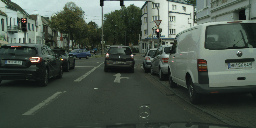

In [54]:
tf.keras.preprocessing.image.array_to_img(batch_img[9])

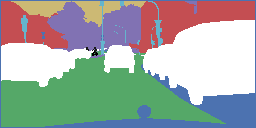

In [55]:
tf.keras.preprocessing.image.array_to_img(generate_img_from_mask(batch_mask[9],cats))

# Building VGG-16 + FCN-8 Model

## Define Pooling Block of VGG

<font color = ""><b> seg_gen </b></font>
><font color = ""><i> Defines  block in the VGG network.</i></font>

In [56]:
def block(x, n_convs, filters, kernel_size, activation, pool_size, pool_stride, block_name):
  '''
  Args:
    x (tensor) -- input image
    n_convs (int) -- number of convolution layers to append
    filters (int) -- number of filters for the convolution layers
    activation (string or object) -- activation to use in the convolution
    pool_size (int) -- size of the pooling layer
    pool_stried (int) -- stride of the pooling layer
    block_name (str) -- name of the block

  Returns:
    tensor containing the max-pooled output of the convolutions
  '''

  for i in range(n_convs):
      x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size,
                                 activation=activation, padding='same', name="{}_conv{}".format(block_name, i + 1))(x)

  x = tf.keras.layers.MaxPooling2D(pool_size=pool_size,
                                   strides=pool_stride, name="{}_pool{}".format(block_name, i+1 ))(x)

  return x

## Pretrained VGG weights

In [57]:
#https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

vgg_weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

## Define VGG-16

<font color = ""><b> VGG_16 </b></font>
><font color = ""><i> defines the VGG encoder</i></font>

In [58]:
def VGG_16(image_input):
  '''

  Args:
    image_input (tensor) - batch of images

  Returns:
    tuple of tensors - output of all encoder blocks plus the final convolution layer
  '''

  # create 5 blocks with increasing filters at each stage.
  # you will save the output of each block (i.e. p1, p2, p3, p4, p5). "p" stands for the pooling layer.
  x = block(image_input,n_convs=2, filters=64, kernel_size=(3,3),
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block1')
  p1= x

  x = block(x,n_convs=2, filters=128, kernel_size=(3,3),
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block2')
  p2 = x

  x = block(x,n_convs=3, filters=256, kernel_size=(3,3),
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block3')
  p3 = x

  x = block(x,n_convs=3, filters=512, kernel_size=(3,3),
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block4')
  p4 = x

  x = block(x,n_convs=3, filters=512, kernel_size=(3,3),
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block5')
  p5 = x

  # create the vgg model
  vgg  = tf.keras.Model(image_input , p5)

  # load the pretrained weights you downloaded earlier
  vgg.load_weights(vgg_weights_path)

  # number of filters for the output convolutional layers
  n = 4096

  # our input images are 224x224 pixels so they will be downsampled to 7x7 after the pooling layers above.
  # we can extract more features by chaining two more convolution layers.
  c6 = tf.keras.layers.Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6")(p5)
  c7 = tf.keras.layers.Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7")(c6)

  # return the outputs at each stage. you will only need two of these in this particular exercise
  # but we included it all in case you want to experiment with other types of decoders.
  return (p1, p2, p3, p4, c7)

## Define FCN 8 Decoder

<font color = ""><b> fcn8_decoder </b></font>
><font color = ""><i> defines the FCN 8 encoder</i></font>

In [59]:
def fcn8_decoder(convs, n_classes):
  '''
  Args:
    convs (tuple of tensors) - output of the encoder network
    n_classes (int) - number of classes

  Returns:
    tensor with shape (height, width, n_classes) containing class probabilities
  '''

  # unpack output of the encoder
  f1, f2, f3, f4, f5 = convs

  # upsample the output of the encoder, then crop extra pixels that were introduced
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False)(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool f4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = ( tf.keras.layers.Conv2D(n_classes , (1,1) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample the resulting tensor of the operation you just did
  o = (tf.keras.layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False ))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)

  # append a softmax to get the class probabilities
  o = (tf.keras.layers.Activation('softmax'))(o)

  return o

## Define final model
<font color = ""><b> segmentation_model </b></font>
><font color = ""><i> Defines the final segmentation model by chaining together the encoder and decoder.
And return keras Model that connects the encoder and decoder networks of the segmentation model
</i></font>

In [60]:
def segmentation_model():

  inputs = tf.keras.layers.Input(shape=(128,256,3))
  convs = VGG_16(image_input=inputs)
  outputs = fcn8_decoder(convs, 8)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

In [61]:
model_fcn8 = segmentation_model()
model_fcn8.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool2 (MaxPooling2D)     (None, 64, 128, 64)  0           block1_conv2[0][0]               
____________________________________________________________________________________________

# Buiding U-net model

## Encoder
<font color = ""><b> conv2d_block </b></font>
><font color = ""><i> Add 2 convolutional layers with the parameters passed to it and return tensor of output features
</i></font>

In [62]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  '''
  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution
  '''
  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)

  return x

<font color = ""><b> encoder_block </b></font>
><font color = ""><i>  Add two convolutional blocks and then perform down sampling on output of convolutions.
</i></font>

In [ ]:
def encoder_block(inputs, n_filters=64):
  '''

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    f - the output features of the convolution block
    p - the maxpooled features with dropout
  '''

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p

<font color = ""><b> encoder </b></font>
><font color = ""><i>  This function defines the encoder or downsampling path.
</i></font>

In [ ]:
def encoder(inputs):
  '''
  Args:
    inputs (tensor) -- batch of input images
  Returns:
    p4 - is the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  '''

  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

## Bottleneck

<font color = ""><b> bottleneck </b></font>
><font color = ""><i>Defines the bottleneck convolutions to extract more features before the upsampling layers.
</i></font>

<font color = "green"><i>
The **bottleneck** in a neural network is just a layer with fewer neurons than the
layer below or above it. Having such a layer encourages the network to compress feature
 representations (of salient features for the target variable) to best fit in the available space.
  Improvements to compression occur due to the goal of reducing the cost function, as for all weight updates.
</i></font>

In [63]:
def bottleneck(inputs):
  bottle_neck = conv2d_block(inputs, n_filters=1024)
  return bottle_neck

## Decoder
<font color = ""><b> decoder_block </b></font>
><font color = ""><i>defines the decoder block of the UNet model
</i></font>

In [64]:
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  '''
  Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    padding (str) -- "same" or "valid", tells if shape will be preserved by zero padding
  Returns:
    c (tensor) -- output features of the decoder block
  '''
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  '''
  Defines the decoder of the UNet chaining together 4 decoder blocks.

  Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

  Returns:
    outputs (tensor) -- the pixel wise label map of the image
  '''

  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs

## Final U-net model

In [65]:
OUTPUT_CHANNELS = 8

def unet():
  '''
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  '''

  # specify the input shape
  inputs = tf.keras.layers.Input(shape=(128, 256,3,))

  # feed the inputs to the encoder
  encoder_output, convs = encoder(inputs)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output)

  # feed the bottleneck and encoder block outputs to the decoder
  # specify the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)

  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

# instantiate the model
model_unet = unet()

# see the resulting model architecture
model_unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 256, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 256, 64) 36928       activation_1[0][0]               
____________________________________________________________________________________________

In [66]:

# Metrics and Loss functions

In [67]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import CategoricalCrossentropy

Here, we want to compare predition and ground truth as far as class prediction is concerned

## IoU Intersection over Union (IoU) for object detection

In [68]:
def class_wise_IoU(y_true,y_pred):

    nb_class = y_true.shape[3]

    # for each pixel, get the slice number which has the highest probability
    y_true = K.argmax(y_true, axis=3)
    y_pred = K.argmax(y_pred,axis=3)

    class_wise_iou = []

    smoothening_factor = 0.00001 # to avoid eventual division by 0

    for i in range(nb_class):
        pred = tf.cast((y_pred == i),tf.float32)
        truth = tf.cast((y_true == i),tf.float32)
        intersection = K.sum(pred * truth)
        y_true_area = K.sum(truth)
        y_pred_area = K.sum(pred)
        combined_area = y_true_area + y_pred_area

        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)

    return tf.convert_to_tensor(class_wise_iou)

In [69]:
def mean_IoU(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    return score

## Dice coef

In [70]:
def wise_dice(y_true,y_pred):

    nb_class = y_true.shape[3]

    # for each pixel, get the slice number which has the highest probability
    y_true = K.argmax(y_true, axis=3)
    y_pred = K.argmax(y_pred,axis=3)
    wise_dice = []
    smoothening_factor = 0.00001 # to avoid eventual division by 0

    for i in range(nb_class):
        pred = tf.cast((y_pred == i),tf.float32)
        truth = tf.cast((y_true == i),tf.float32)
        intersection = K.sum(pred * truth)
        y_true_area = K.sum(truth)
        y_pred_area = K.sum(pred)
        combined_area = y_true_area + y_pred_area

        dice = 2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        wise_dice.append(dice)

    return tf.convert_to_tensor(wise_dice)

In [71]:
def mean_dice(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

## Dice loss

In [72]:
#Loss must be decreasing fonction
def dice_loss(y_true, y_pred):
    return (1 - mean_dice(y_true,y_pred))

## Total Loss : combination of cross entropy and dice

In [73]:
cce = tf.keras.losses.CategoricalCrossentropy()

def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    loss = cce(y_true, y_pred).numpy() + (3*dice_loss(y_true, y_pred))
    return loss

# Callbacks

## Early stopping

In [74]:
es = tf.keras.callbacks.EarlyStopping(mode='min', monitor='val_loss', patience=6, verbose=1)

# Exemple dummy training

## With categorical crossentropy

In [75]:
sgd = tf.keras.optimizers.SGD(lr=1E-2, momentum=0.9, nesterov=True)


In [76]:
model_unet.compile(loss='categorical_crossentropy',
              #optimizer=sgd,
              metrics=['accuracy','categorical_crossentropy',mean_dice,mean_IoU],

              )

In [77]:
model_unet.fit(train_gen,epochs=100)

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


21/21 [==============================] - 25s 1s/step - loss: 9.7362 - acc: 0.3632 - categorical_crossentropy: 9.7362 - mean_dice: 0.3618 - mean_IoU: 0.2218

In [78]:
hist = model_unet.fit(X_train_dummy,y_train_dummy,validation_data=(X_test_dummy,y_test_dummy),batch_size=10,epochs=3,callbacks=[es])

Train on 100 samples, validate on 20 samples
Epoch 1/3
100/100 [==============================] - 9s 90ms/sample - loss: 11.1845 - acc: 0.3022 - categorical_crossentropy: 11.1845 - mean_dice: 0.3028 - mean_IoU: 0.1785 - val_loss: 16.1176 - val_acc: 3.0518e-05 - val_categorical_crossentropy: 16.1176 - val_mean_dice: 3.2043e-05 - val_mean_IoU: 1.6785e-05

In [79]:
hist.history

{'loss': [11.18454704284668, 11.184788036346436, 11.184718990325928],
 'acc': [0.30222654, 0.3022116, 0.30221587],
 'categorical_crossentropy': [11.184546, 11.184788, 11.184719],
 'mean_dice': [0.302814, 0.30279413, 0.30280444],
 'mean_IoU': [0.17846268, 0.17849152, 0.17872284],
 'val_loss': [16.117605209350586, 16.117605209350586, 16.117605209350586],
 'val_acc': [3.0517578e-05, 3.0517578e-05, 3.0517578e-05],
 'val_categorical_crossentropy': [16.117605, 16.117605, 16.117605],
 'val_mean_dice': [3.204341e-05, 3.204341e-05, 3.204341e-05],
 'val_mean_IoU': [1.6784898e-05, 1.6784898e-05, 1.6784898e-05]}

# Building smaller image dataset for Uploading in new folder "img_128_256"

To save ressource, we'll resize all images (train,test,validation) to 128x256

In [80]:
def reduce_size_folder(origin_path,dest_path,height,width):
    isExist = os.path.exists(path)

    if not isExist:

      # Create a new directory because it does not exist
      os.makedirs(path)
      print("The new directory is created!")
    filenames = os.listdir(origin_path)
    for file in filenames:
        origin_file=origin_path+'/'+file
        img = tf.keras.preprocessing.image.load_img(origin_file,target_size=(height,width))
        img.save(dest_path+'/'+file)

In [81]:
CURRENT_WORKING_DIRRECTORY = os.getcwd()

In [82]:
def reduce_size_folder(origin_path,dest_path,height,width):
    isExist = os.path.exists(dest_path)

    if not isExist:
      # Create a new directory because it does not exist
      os.makedirs(dest_path)
      print("The directory with resize file is created!:",dest_path)
    actual_path= r''+CURRENT_WORKING_DIRRECTORY+'\data\images'+origin_path


    #print (type(actual_path.encode('unicode_escape')))
    filenames = os.listdir(actual_path)
    for file in filenames:
        origin_file=actual_path+'\\'+file
        if not os.path.exists(dest_path+'\\'+origin_path):
          # Create a new directory because it does not exist
          os.makedirs(dest_path+'\\'+origin_path)

          print("The directory with resize file is created!:",dest_path+'\\'+origin_path)

        img = tf.keras.preprocessing.image.load_img(origin_file,target_size=(height,width))
        img.save(dest_path+'\\'+origin_path+'\\'+file)

In [83]:
DESTINATION_PATH = CURRENT_WORKING_DIRRECTORY+'\data\images\img_128_256'

In [84]:
reduce_size_folder('\masks',
                   DESTINATION_PATH,
                   128,256)

In [85]:
reduce_size_folder('\\train',
                   DESTINATION_PATH,
                   128,256)

In [86]:
reduce_size_folder('\\test\\test',
                   DESTINATION_PATH,
                   128,256)

In [87]:
reduce_size_folder('\\test\mask',
                   DESTINATION_PATH,
                   128,256)

In [88]:
reduce_size_folder('\\validation\images',
                   DESTINATION_PATH,
                   128,256)

In [89]:
reduce_size_folder('\\validation\images',
                   DESTINATION_PATH,
                   128,256)

